In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils,datasets
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import sys

# Loading the data

In [2]:
choice = int(input("On which dataset do you want to apply the model?\nEnter 1 for GENKI\n2 for SFEW"))
if choice == 1:
    train_data_dir = 'D:/HDD_downloads/Facial Expression Database/2_GENKI/TRAIN'  
    test_data_dir = 'D:/HDD_downloads/Facial Expression Database/2_GENKI/TEST'
elif choice == 2:
    train_data_dir = 'D:/HDD_downloads/Facial Expression Database/3_SFEW/Set2'
    test_data_dir = 'D:/HDD_downloads/Facial Expression Database/3_SFEW/Set1'
else:
    print('wrong choice')
    sys.exit(0)

#Applying Transformation
train_transforms = transforms.Compose([
                                transforms.Grayscale(num_output_channels=1),
                                #transforms.RandomCrop(48, padding=4, padding_mode='reflect'),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.Resize(size = (90,90)),
                                transforms.ToTensor()])
                                #transforms.Normalize((0.5), (0.5), inplace=True)])

test_transforms = transforms.Compose([
                                transforms.Grayscale(num_output_channels=1),
                                transforms.Resize(size = (90,90)),
                                transforms.ToTensor()])
                                #transforms.Normalize((0.5), (0.5))])


train_data = datasets.ImageFolder(root=train_data_dir, transform=train_transforms)                                       
test_data = datasets.ImageFolder(root=test_data_dir , transform=test_transforms)


random_seed = 42
torch.manual_seed(random_seed)

batch_num = 35     #50

trainloader = DataLoader(train_data, batch_num, shuffle=True, num_workers=4, pin_memory=True)
testloader = DataLoader(test_data, batch_num*2, num_workers=4, pin_memory=True)   #batch_num*2 for genki

On which dataset do you want to apply the model?
Enter 1 for GENKI
2 for SFEW1


# Display Image

123


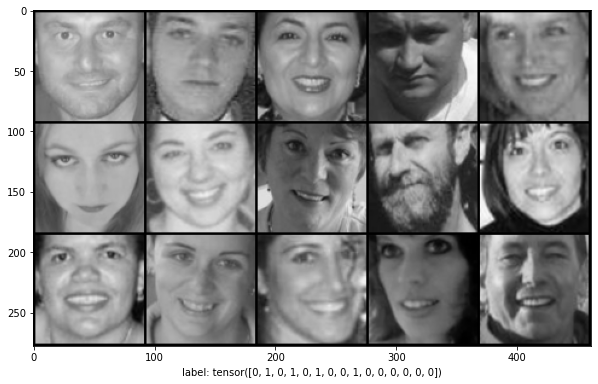

In [3]:
def showImages(dataset):
    loader = DataLoader(dataset,batch_size=15,shuffle=True)
    print(len(loader))
    batch = next(iter(loader))
    images , labels= batch    #labels corresponds to the ith folder from where the image is picked
    grid = utils.make_grid(images,nrow=5)
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(grid,(1,2,0)))  #to convert the dimentions from [width,height,channels] to [height,channels,width] then transpose
    plt.xlabel(f'label: {labels}')
    
showImages(train_data)

# Creating the model
##creating the base class

In [4]:
###  The Accuracy calculating function...................
from sklearn.metrics import confusion_matrix

predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    global predlist
    global lbllist
    predlist=torch.cat([predlist,preds.view(-1)])
    lbllist=torch.cat([lbllist,labels.view(-1)])
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [5]:
class FERBase(nn.Module):
    
    # this takes is batch from training dl
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                     # calls the forward().  calls the training model and generates predictions
        loss = F.cross_entropy(out, labels)    # calculates loss compare to real labels using cross entropy
        acc = accuracy(out, labels) 
        return loss,acc
    
    # this takes in batch from validation dl
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)    #calls the forward()
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)            # calls the accuracy function to measure the accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}   #there are gradients associated with the loss in PyTorch which are used while training neural network model. So, while displaying the loss we don’t need this gradient and hence, .detach() method.

    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()    # finds out the mean loss of the epoch batch
        
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()       # finds out the mean acc of the epoch batch
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}  # .item() just converts tensor to python object
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, train_acc: {:.4f}%, val_loss: {:.4f}, test_acc: {:.4f}%".format(
            epoch, result['lrs'][-1], result['train_loss'], result['train_acc']*100, result['val_loss'], result['val_acc']*100))

# Creating the Model class

In [6]:
def conv_block(in_chnl, out_chnl, pool=False, padding=1):
    layers = [
        nn.Conv2d(in_chnl, out_chnl, kernel_size=3, padding=padding),
        nn.BatchNorm2d(out_chnl),
        nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
        
    return nn.Sequential(*layers)   #if the operation sequence is not defined inside the sequential() itself, then *layers is used

class FERModel(FERBase):
    def __init__(self, in_chnls, num_cls):
        super().__init__()
        
        self.convtemp1 = conv_block(in_chnls, 16)
        self.convtemp2 = conv_block(16, 32)
        self.resnettemp1 = nn.Sequential(conv_block(32,32), conv_block(32,32)) 
        
        self.conv1 = conv_block(32, 64, pool=True)           # 64x24x24 
        self.conv2 = conv_block(64, 128, pool=True)                # 128x12x12
        self.resnet1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))    # Resnet layer 1: includes 2 conv2d
        
        self.conv3 = conv_block(128, 256, pool=True)       # 256x6x6 
        self.conv4 = conv_block(256, 512, pool=True)       # 512x3x3
        self.resnet2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))    # Resnet layer 2: includes 2 conv2d
         
        self.classifier = nn.Sequential(nn.MaxPool2d(3),
                                        nn.Flatten(),
                                        nn.Linear(512, num_cls))    # num_cls
        
    def forward(self, xb):
        out = self.convtemp1(xb)
        out = self.convtemp2(out)
        out = self.resnettemp1(out) + out
        
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.resnet1(out) + out   #output from previous operation is added directly to this layer 
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.resnet2(out) + out
        
        return self.classifier(out)
    
### create object of the model........................     
if choice == 1:
    model = FERModel(1, 2)   #this actually calls the forward(),which is possible due to nn.Module
else:
    model = FERModel(1, 7)

shape of image:  torch.Size([35, 1, 90, 90])
shape of output:  torch.Size([35, 2])
Output:  tensor([ 0.0138, -0.1553], grad_fn=<SelectBackward0>)


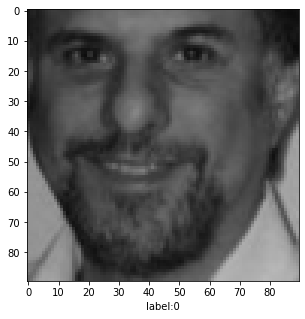

In [7]:
for images, lbl in trainloader:
    print('shape of image: ', images.shape)
    out = model(images)
    print('shape of output: ', out.shape)
    print('Output: ', out[0])
    grid = utils.make_grid(images[0],nrow=1)
    plt.figure(figsize=(5,5))
    plt.imshow(np.transpose(grid,(1,2,0)))
    plt.xlabel(f'label:{lbl[0]}')
    break

# Training the Model

In [8]:
@torch.no_grad()    # this is for stopping the model from keeping track of old parameters
def evaluate(model, testloader):
    # This function will evaluate the model and give back the val acc and loss
    model.eval()  #turns off droput and batchnorm layers, since they are not required during validation
    outputs = [model.validation_step(batch) for batch in testloader]
    return model.validation_epoch_end(outputs)

# getting the current learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# this fit function follows the intuition of 1cycle lr
def fit(epochs, max_lr, model, train_loader=trainloader, testloader=testloader, weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []    #keep track of the evaluation results
    
    # setting upcustom optimizer including weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # setting up 1cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(trainloader))
    
    for epoch in range(epochs):
        # training
        model.train()
        train_losses = []
        train_acc = []
        lrs = []
        for batch in trainloader:
            loss , acc = model.training_step(batch)
            train_losses.append(loss)
            train_acc.append(acc)
            loss.backward()
            
            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()    #every torch.optim class emplements the step() which updates the parameters
            optimizer.zero_grad()  #Sets the gradients of all optimized torch.Tensors to zero
            
            # record the lr
            lrs.append(get_lr(optimizer))
            sched.step()
            
        #validation
        result = evaluate(model, testloader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [9]:
evaluate(model, testloader)

{'val_loss': 0.6949214339256287, 'val_acc': 0.4724867641925812}

In [10]:
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4

In [11]:
%%time
print("working on choice",choice)
history = fit(35, max_lr, model, weight_decay=weight_decay, grad_clip=grad_clip)

working on choice 1
Epoch [0], last_lr: 0.00006, train_loss: 0.5936, train_acc: 68.6729%, val_loss: 0.5904, test_acc: 69.0278%
Epoch [1], last_lr: 0.00012, train_loss: 0.3791, train_acc: 83.0062%, val_loss: 0.4640, test_acc: 83.5251%
Epoch [2], last_lr: 0.00022, train_loss: 0.2862, train_acc: 88.3526%, val_loss: 0.2860, test_acc: 89.1534%
Epoch [3], last_lr: 0.00034, train_loss: 0.2839, train_acc: 89.3135%, val_loss: 0.4716, test_acc: 85.3373%
Epoch [4], last_lr: 0.00048, train_loss: 0.2486, train_acc: 90.1221%, val_loss: 0.3429, test_acc: 88.8161%
Epoch [5], last_lr: 0.00063, train_loss: 0.2052, train_acc: 91.8535%, val_loss: 0.3093, test_acc: 88.5979%
Epoch [6], last_lr: 0.00076, train_loss: 0.2038, train_acc: 93.1441%, val_loss: 0.4950, test_acc: 82.8042%
Epoch [7], last_lr: 0.00087, train_loss: 0.1887, train_acc: 92.6653%, val_loss: 0.2767, test_acc: 89.3056%
Epoch [8], last_lr: 0.00095, train_loss: 0.1793, train_acc: 93.2551%, val_loss: 0.2257, test_acc: 91.4616%
Epoch [9], last_l

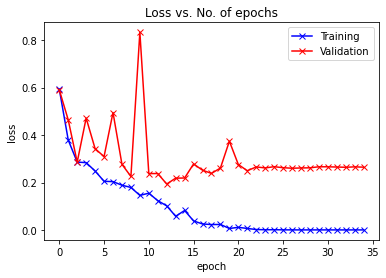

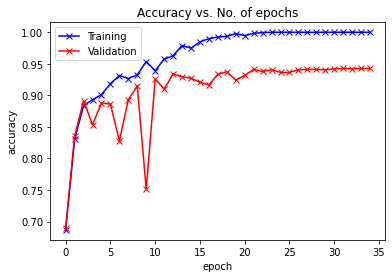

In [14]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracy(history):
    train_losses = [x.get('train_acc') for x in history]
    val_losses = [x['val_acc'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_losses(history)
plt.figure()
plot_accuracy(history)
#plot_lrs(history)

In [15]:
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print("The confusion Matrix:")
print(conf_mat)

The confusion Matrix:
[[64609  6213]
 [ 3261 56308]]
